<a href="https://colab.research.google.com/github/hbvictorio/Tech-Challenge---Fase-2---Henrique/blob/main/Tech_Challenge_C%C3%B3digo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Código Python

In [16]:
!pip install tensorflow mplfinance tabulate

In [17]:
# ==============================================================================
# CÉLULA 1: CONFIGURAÇÃO, INSTALAÇÃO E TRATAMENTO DA BASE
# (Contém todos os imports necessários para as Células 2 a 7)
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from datetime import timedelta

# Imports para o modelo sequencial (LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# URL do arquivo CSV no GitHub (conforme a fonte)
url_arquivo_github = "https://raw.githubusercontent.com/hbvictorio/Tech-Challenge---Fase-2---Henrique/refs/heads/main/Dados%20Hist%C3%B3ricos%20-%20Ibovespa.csv"

# --- Carregamento e Pré-processamento dos Dados ---
print("--- 1. Aquisição e Tratamento da Base (Requisito Storytelling) ---")

try:
    # Carregamento do CSV
    df = pd.read_csv(url_arquivo_github, sep=',', header=0)
except Exception as e:
    print(f"Erro ao carregar o arquivo do GitHub: {e}")
    raise

# Renomear Colunas
df.columns = ['Data', 'Ultimo', 'Abertura', 'Maxima', 'Minima', 'Volume', 'Variacao_Perc']

# Tratamento de Datas e Ordenação (Ascendente)
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y', errors='coerce')
df = df.sort_values(by='Data').reset_index(drop=True)

# Tratamento das Colunas de Preço (OHLC)
# Remover pontos de milhar, pois os dados usam o formato brasileiro (Ex: "146.237")
colunas_preco = ['Ultimo', 'Abertura', 'Maxima', 'Minima']
for col in colunas_preco:
    df[col] = df[col].astype(str).str.replace('.', '', regex=False)
    df[col] = df[col].astype(float)

# Remover linhas com valores ausentes nas colunas principais
df = df.dropna(subset=['Ultimo', 'Data'])

print(f"Base de dados tratada. Período: {df['Data'].min().strftime('%d.%m.%Y')} a {df['Data'].max().strftime('%d.%m.%Y')}.")


--- 1. Aquisição e Tratamento da Base (Requisito Storytelling) ---
Base de dados tratada. Período: 30.09.2015 a 30.09.2025.


In [18]:
# ==============================================================================
# CÉLULA 2: ENGENHARIA DE ATRIBUTOS E ANÁLISE DE SETEMBRO/2025
# ==============================================================================
print("\n--- 2. Engenharia de Atributos e Análise de Setembro/2025 ---")

# 2.1 Engenharia de Atributos Mínima para Previsão
df['Target'] = (df['Ultimo'].shift(-1) > df['Ultimo']).astype(int)
df['Ultimo_Lag1'] = df['Ultimo'].shift(1)
df = df.dropna()

features = ['Ultimo_Lag1']
X = df[features]
Y = df['Target']

# Divisão para Treinamento e Previsão
X_previsao_final = X.iloc[-1:].copy()
df_base_treino = df.iloc[:-1].copy()

# Escalonamento
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_base_treino[features])
X_previsao_scaled = scaler.transform(X_previsao_final)

# 2.2 Treinamento do Modelo (Random Forest)
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_scaled, df_base_treino['Target'])

# 2.3 Previsão D+1
data_ultima = df.iloc[-1]['Data']
valor_ultimo = df.iloc[-1]['Ultimo']
data_previsao = data_ultima + timedelta(days=1)

previsao_bruta = modelo.predict(X_previsao_scaled)[0]
tendencia_previsao = '↑' if previsao_bruta == 1 else '↓'

print(f"Previsão de tendência do modelo para D+1: {tendencia_previsao}")

# ----------------------------------------------------------------------
# Tabela 1: Dados de Setembro/2025
# ----------------------------------------------------------------------
df_setembro = df[(df['Data'].dt.year == 2025) & (df['Data'].dt.month == 9)].copy()
df_setembro['Tendência'] = df_setembro['Target'].apply(lambda x: '↑' if x == 1 else '↓')

if not df_setembro.empty:
    df_setembro.loc[df_setembro.index[-1], 'Tendência'] = '—'

df_analise = df_setembro[['Data', 'Ultimo', 'Abertura', 'Maxima', 'Minima', 'Tendência']].sort_values(by='Data', ascending=False)

print("\nTabela 1: Dados Analisados do IBOVESPA - Setembro/2025 (Amostra)")
print(df_analise.head(15).to_markdown(index=False))
print("-" * 70)



--- 2. Engenharia de Atributos e Análise de Setembro/2025 ---
Previsão de tendência do modelo para D+1: ↓

Tabela 1: Dados Analisados do IBOVESPA - Setembro/2025 (Amostra)
| Data                |   Ultimo |   Abertura |   Maxima |   Minima | Tendência   |
|:--------------------|---------:|-----------:|---------:|---------:|:------------|
| 2025-09-30 00:00:00 |   146237 |     146337 |   147578 |   145774 | —           |
| 2025-09-29 00:00:00 |   146337 |     145447 |   147558 |   145447 | ↓           |
| 2025-09-26 00:00:00 |   145447 |     145326 |   146235 |   145146 | ↑           |
| 2025-09-25 00:00:00 |   145306 |     146492 |   146519 |   145187 | ↑           |
| 2025-09-24 00:00:00 |   146492 |     146426 |   146585 |   146067 | ↓           |
| 2025-09-23 00:00:00 |   146425 |     145112 |   147178 |   145107 | ↑           |
| 2025-09-22 00:00:00 |   145109 |     145864 |   145864 |   144117 | ↑           |
| 2025-09-19 00:00:00 |   145865 |     145499 |   146399 |   145496 | ↓


--- 3. Gráfico de Balanceamento de Classes ---


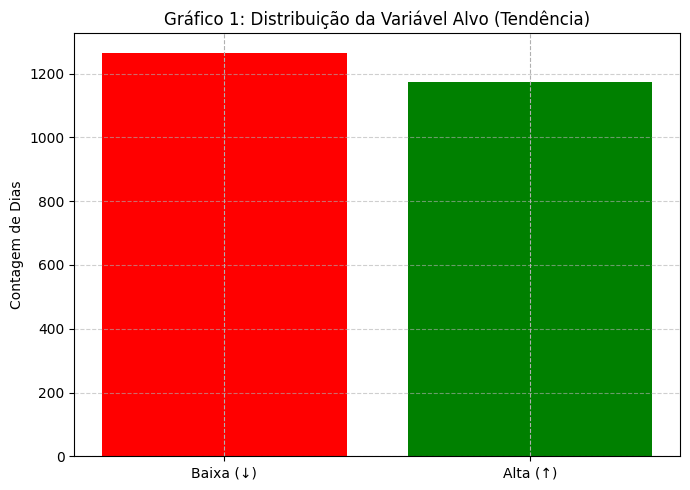

Gráfico 1 gerado com sucesso.


In [19]:
# ==============================================================================
# CÉLULA 3: GRÁFICO DE BALANCEAMENTO DE CLASSES (TARGET BALANCE)
# ==============================================================================
print("\n--- 3. Gráfico de Balanceamento de Classes ---")

# Features adicionais
df['Ultimo_Lag5'] = df['Ultimo'].shift(5)
df['MM_5d'] = df['Ultimo'].rolling(window=5).mean().shift(1)
df['Volatilidade_10d'] = df['Ultimo'].rolling(window=10).std().shift(1)
df_limpo = df.dropna()

dias_teste = 30
df_treino = df_limpo.iloc[:-dias_teste]

target_counts = df_treino['Target'].value_counts()
labels = ['Baixa (↓)', 'Alta (↑)']

plt.figure(figsize=(7, 5))
plt.bar(labels, target_counts.values, color=['red', 'green'])
plt.title('Gráfico 1: Distribuição da Variável Alvo (Tendência)')
plt.ylabel('Contagem de Dias')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Gráfico 1 gerado com sucesso.")



--- 5. Fechamento vs. Médias Móveis ---


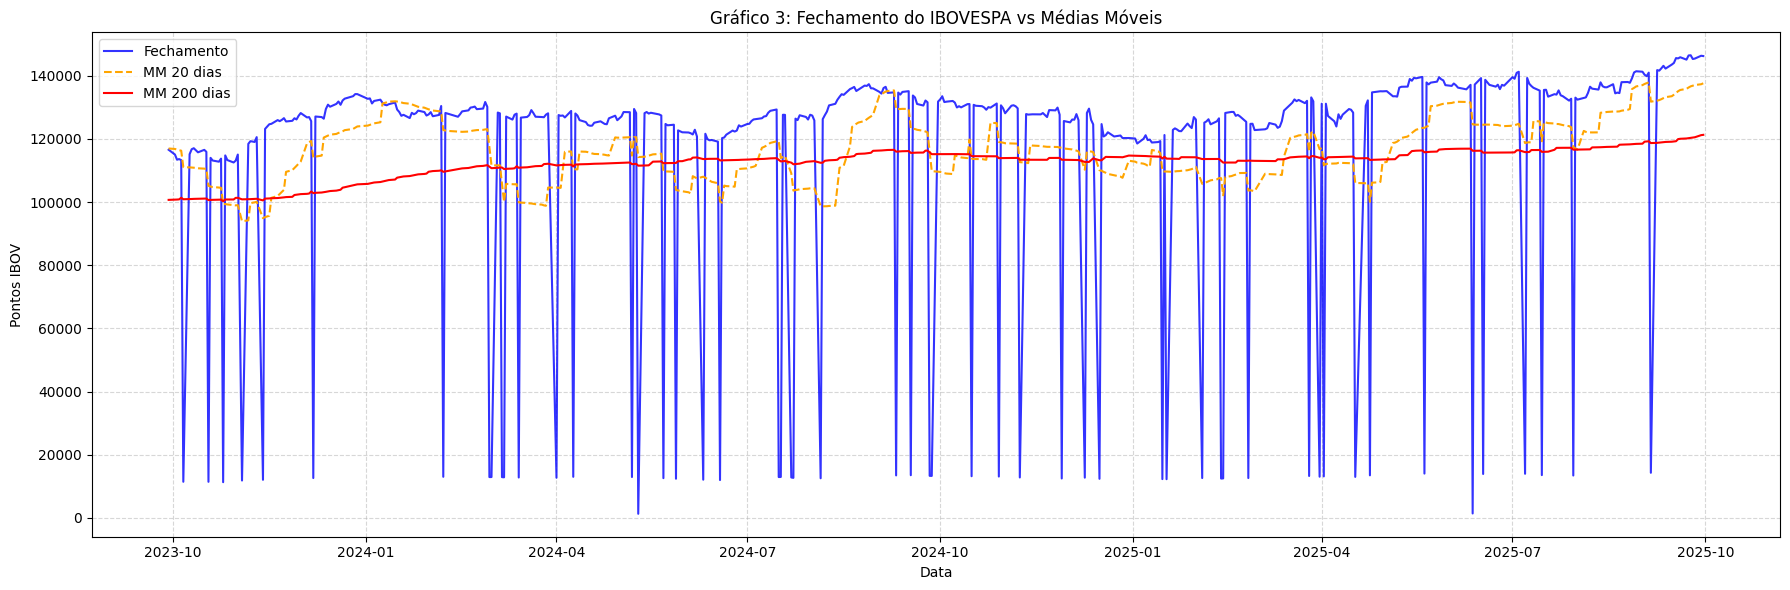

Gráfico 3 gerado com sucesso.


In [20]:
# ==============================================================================
# CÉLULA 5: FECHAMENTO VS. MÉDIAS MÓVEIS
# ==============================================================================
print("\n--- 5. Fechamento vs. Médias Móveis ---")

df['MM_20d_plot'] = df['Ultimo'].rolling(window=20).mean()
df['MM_200d_plot'] = df['Ultimo'].rolling(window=200).mean()

df_mm_plot = df.iloc[-500:].dropna()

plt.figure(figsize=(18, 6))
plt.plot(df_mm_plot['Data'], df_mm_plot['Ultimo'], label='Fechamento', color='blue', alpha=0.8)
plt.plot(df_mm_plot['Data'], df_mm_plot['MM_20d_plot'], label='MM 20 dias', color='orange', linestyle='--')
plt.plot(df_mm_plot['Data'], df_mm_plot['MM_200d_plot'], label='MM 200 dias', color='red', linestyle='-')

plt.title('Gráfico 3: Fechamento do IBOVESPA vs Médias Móveis')
plt.xlabel('Data')
plt.ylabel('Pontos IBOV')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print("Gráfico 3 gerado com sucesso.")



--- 6. Avaliação e Comparação de Modelos ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Tabela 3: Comparação de Acurácia dos Modelos
Meta: Acurácia mínima de 75% no conjunto de teste (30 dias).
| Modelo              |   Acurácia | Atingiu 75%   |
|:--------------------|-----------:|:--------------|
| Random Forest       |   0.533333 | Não           |
| Regressão Logística |   0.466667 | Não           |
| LSTM                |   0.566667 | Não           |


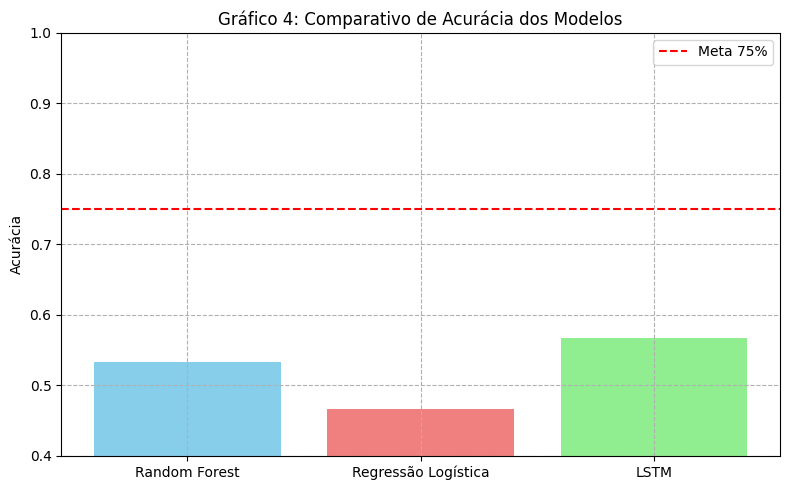

In [21]:
# ==============================================================================
# CÉLULA 6: COMPARAÇÃO DE MODELOS (LR, RF, LSTM)
# ==============================================================================
print("\n--- 6. Avaliação e Comparação de Modelos ---")

features_full = ['Ultimo_Lag1', 'Ultimo_Lag5', 'MM_5d', 'Volatilidade_10d']
df_limpo = df.dropna(subset=features_full)

dias_teste = 30
df_treino_full = df_limpo.iloc[:-dias_teste]
df_teste_full = df_limpo.iloc[-dias_teste:].copy()

X_treino_full = df_treino_full[features_full]
Y_treino_full = df_treino_full['Target']
X_teste_full = df_teste_full[features_full]
Y_teste_full = df_teste_full['Target']

scaler_full = MinMaxScaler()
X_treino_scaled_full = scaler_full.fit_transform(X_treino_full)
X_teste_scaled_full = scaler_full.transform(X_teste_full)
X_previsao_scaled_full = scaler_full.transform(df_limpo.iloc[-1:][features_full])

acuracias = {}

# --- Random Forest ---
modelo_rf_full = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5, min_samples_leaf=5)
modelo_rf_full.fit(X_treino_scaled_full, Y_treino_full)
acuracias['Random Forest'] = accuracy_score(Y_teste_full, modelo_rf_full.predict(X_teste_scaled_full))

# --- Regressão Logística ---
modelo_lr = LogisticRegression(random_state=42, solver='liblinear')
modelo_lr.fit(X_treino_scaled_full, Y_treino_full)
acuracias['Regressão Logística'] = accuracy_score(Y_teste_full, modelo_lr.predict(X_teste_scaled_full))

# --- LSTM ---
X_treino_lstm = X_treino_scaled_full.reshape((X_treino_scaled_full.shape[0], 1, X_treino_scaled_full.shape[1]))
X_teste_lstm = X_teste_scaled_full.reshape((X_teste_scaled_full.shape[0], 1, X_teste_scaled_full.shape[1]))

modelo_lstm = Sequential([
    LSTM(units=50, activation='relu', input_shape=(1, X_treino_scaled_full.shape[1])),
    Dense(1, activation='sigmoid')
])
modelo_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modelo_lstm.fit(X_treino_lstm, Y_treino_full, epochs=5, batch_size=32, verbose=0)
_, acuracia_lstm = modelo_lstm.evaluate(X_teste_lstm, Y_teste_full, verbose=0)
acuracias['LSTM'] = acuracia_lstm

# --- Tabela e Gráfico ---
df_acuracia = pd.DataFrame(list(acuracias.items()), columns=['Modelo', 'Acurácia'])
df_acuracia['Atingiu 75%'] = np.where(df_acuracia['Acurácia'] >= 0.75, 'Sim', 'Não')

print("\nTabela 3: Comparação de Acurácia dos Modelos")
print(f"Meta: Acurácia mínima de 75% no conjunto de teste ({dias_teste} dias).")
print(df_acuracia.to_markdown(index=False))

plt.figure(figsize=(8, 5))
plt.bar(df_acuracia['Modelo'], df_acuracia['Acurácia'], color=['skyblue', 'lightcoral', 'lightgreen'])
plt.axhline(y=0.75, color='r', linestyle='--', label='Meta 75%')
plt.title('Gráfico 4: Comparativo de Acurácia dos Modelos')
plt.ylabel('Acurácia')
plt.ylim(0.4, 1.0)
plt.legend()
plt.tight_layout()
plt.show()



--- 7. Visualização Histórica e Previsão Final ---


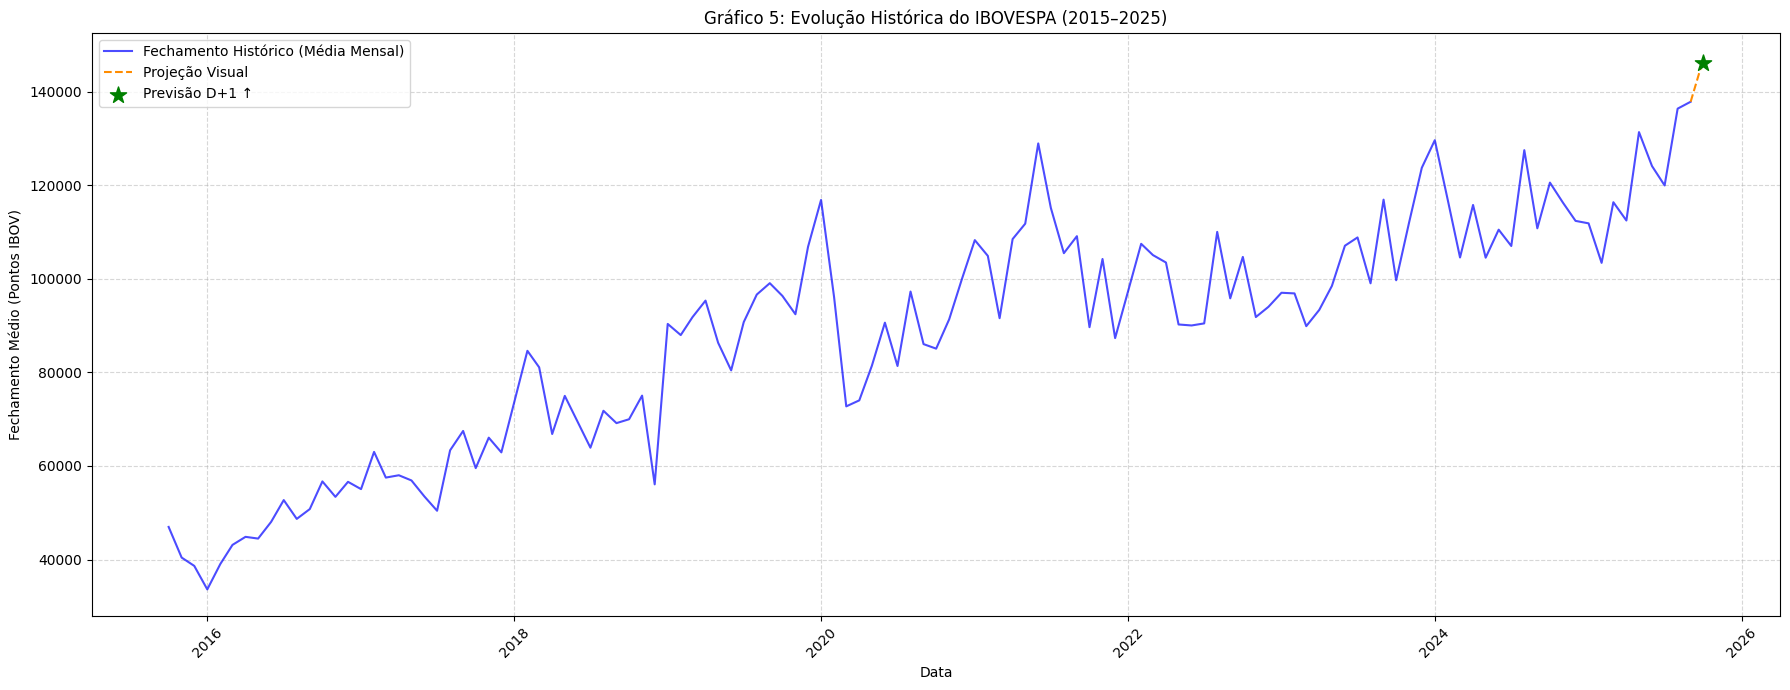


Previsão da Tendência do IBOVESPA para D(n+1)
| Dia   | Valor             | Tendência   |
|:------|:------------------|:------------|
| D1    | 146337.0          | —           |
| D2    | 146237.0          | ↓           |
| D3    | Previsão (146237) | ↑           |


In [22]:
# ==============================================================================
# CÉLULA 7: GRÁFICO HISTÓRICO ESTENDIDO E PREVISÃO FINAL
# ==============================================================================
print("\n--- 7. Visualização Histórica e Previsão Final ---")

data_ultima = df_limpo.iloc[-1]['Data']
valor_ultimo = df_limpo.iloc[-1]['Ultimo']
data_previsao = data_ultima + timedelta(days=1)

previsao_bruta = modelo_rf_full.predict(X_previsao_scaled_full)[0]
tendencia_previsao = '↑' if previsao_bruta == 1 else '↓'

df_hist_plot = df_limpo[['Data', 'Ultimo']].copy()
df_hist_plot['Mes_Ano'] = df_hist_plot['Data'].dt.to_period('M')
df_mensal = df_hist_plot.groupby('Mes_Ano')['Ultimo'].mean().reset_index()
df_mensal['Data_Plot'] = df_mensal['Mes_Ano'].apply(lambda x: x.start_time)

data_inicio_plot = pd.to_datetime('2015-01-01')
data_fim_plot = pd.to_datetime('2025-10-01')

valor_previsao_plot = valor_ultimo
if tendencia_previsao == '↑':
    cor_previsao = 'green'
    valor_projecao = valor_ultimo * 1.005
else:
    cor_previsao = 'red'
    valor_projecao = valor_ultimo * 0.995

future_dates = pd.to_datetime([df_mensal['Data_Plot'].iloc[-1], data_fim_plot])
future_values = [df_mensal['Ultimo'].iloc[-1], valor_projecao]

plt.figure(figsize=(18, 7))
plt.plot(df_mensal['Data_Plot'], df_mensal['Ultimo'], label='Fechamento Histórico (Média Mensal)', color='blue', alpha=0.7)
plt.plot(future_dates, future_values, linestyle='--', color='darkorange', label='Projeção Visual')
plt.scatter(data_previsao, valor_previsao_plot, color=cor_previsao, s=150, zorder=5, marker='*', label=f'Previsão D+1 {tendencia_previsao}')

plt.title('Gráfico 5: Evolução Histórica do IBOVESPA (2015–2025)')
plt.xlabel('Data')
plt.ylabel('Fechamento Médio (Pontos IBOV)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# --- Tabela Final ---
df_output = df_limpo[['Data', 'Ultimo']].tail(2).copy()
df_output.rename(columns={'Data': 'Fechamento (Dia)', 'Ultimo': 'Valor'}, inplace=True)
df_output.reset_index(drop=True, inplace=True)

valor_d1 = df_output.loc[0, 'Valor']
valor_d2 = df_output.loc[1, 'Valor']
df_output.loc[0, 'Tendência'] = '—'
df_output.loc[1, 'Tendência'] = '↑' if valor_d2 > valor_d1 else '↓'

novo_dia = pd.DataFrame({
    'Fechamento (Dia)': [data_previsao.strftime('%d.%m.%Y')],
    'Valor': [f"Previsão ({valor_d2:.0f})"],
    'Tendência': [tendencia_previsao]
})

df_output = pd.concat([df_output, novo_dia], ignore_index=True)
df_output['Dia'] = 'D' + (df_output.index + 1).astype(str)
df_output_final = df_output[['Dia', 'Valor', 'Tendência']]

print("\n" + "="*70)
print("Previsão da Tendência do IBOVESPA para D(n+1)")
print("="*70)
print(df_output_final.to_markdown(index=False))
